# Exploratory Data Analysis

This notebook is for doing data checks and quick visualizations. 

In [ ]:
# standard import
# warnings
import warnings

import duckdb

# geospatial
import geopandas as gpd
from shapely import wkt

warnings.filterwarnings("ignore")

# establish database connections
conn = duckdb.connect("../data/lake/database.duckdb")

## Overview

Load and merge tables. Note that we are using `bright_ti4` as this is used particularly for thermal anomalies and fires. `bright_ti5` is used for cloud and surface temperature measurements.

### Admin boundaries

In [2]:
# download data
!wget -P ../data https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/THA/ADM1/geoBoundaries-THA-ADM1_simplified.geojson

--2025-05-21 17:20:29--  https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/THA/ADM1/geoBoundaries-THA-ADM1_simplified.geojson
Resolving github.com (github.com)... 20.205.243.166, 64:ff9b::14cd:f3a6
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/THA/ADM1/geoBoundaries-THA-ADM1_simplified.geojson [following]
--2025-05-21 17:20:30--  https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/THA/ADM1/geoBoundaries-THA-ADM1_simplified.geojson
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiti

<Axes: >

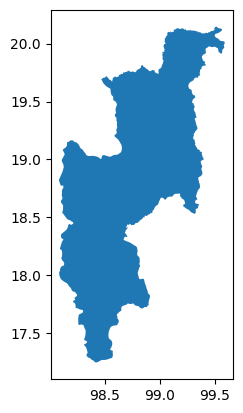

In [3]:
# convert to geodataframe
th_bounds = gpd.read_file("../data/geoBoundaries-THA-ADM1_simplified.geojson")
th_bounds = th_bounds.set_crs(epsg=4326)
chiang_mai_bounds = th_bounds[th_bounds["shapeName"] == "Chiang Mai Province"]
chiang_mai_bounds.plot()

### NASA FIRMS

In [4]:
# nasa_firms data
firms_df = conn.sql("""
    SELECT
        acq_datetime,
        (bright_ti4 - 273.15) AS bright_ti4, -- convert to Celsius
        frp,
        geometry
    FROM public.nasa_firms_clean
    WHERE (confidence == 'n' OR confidence == 'h') AND (daynight == 'D')
    """).fetchdf()

firms_df["geometry"] = firms_df["geometry"].apply(wkt.loads)
firms_df = gpd.GeoDataFrame(firms_df, geometry="geometry")
firms_df = firms_df.set_crs(epsg="4326")

firms_df.head(5)

,acq_datetime,bright_ti4,frp,geometry
0,2025-02-01 06:16:00,61.130005,3.27,POINT (99.19873 7.77023)
1,2025-02-01 06:16:00,69.959991,10.58,POINT (99.31365 7.78971)
2,2025-02-01 06:16:00,58.779999,4.03,POINT (99.05454 9.15764)
3,2025-02-01 06:16:00,55.420013,3.33,POINT (98.98035 9.35155)
4,2025-02-01 06:16:00,75.649994,3.48,POINT (99.82351 12.5212)


In [32]:
# intersect with chiang mai bounds
firms_chiang_mai_df = gpd.sjoin(firms_df, chiang_mai_bounds, how="inner")
firms_chiang_mai_df = firms_chiang_mai_df.drop(
    columns=[
        "shapeName",
        "shapeISO",
        "shapeID",
        "shapeGroup",
        "shapeType",
        "index_right",
    ]
)
firms_chiang_mai_df = firms_chiang_mai_df.sort_values(
    by=["acq_datetime"], ascending=True
)
# firms_chiang_mai_df['geometry'] = firms_chiang_mai_df['geometry'].apply(wkt.loads)
firms_chiang_mai_df = gpd.GeoDataFrame(firms_chiang_mai_df, geometry="geometry")
firms_chiang_mai_df = firms_chiang_mai_df.set_crs(epsg=4326)
firms_chiang_mai_df = firms_chiang_mai_df[
    ["acq_datetime", "bright_ti4", "frp", "geometry"]
]

firms_chiang_mai_df.head(5)

,acq_datetime,bright_ti4,frp,geometry
310,2025-02-01 06:18:00,68.490021,6.19,POINT (98.58241 17.60752)
311,2025-02-01 06:18:00,63.800018,6.19,POINT (98.58618 17.60821)
315,2025-02-01 06:18:00,60.450012,2.96,POINT (98.83205 17.77735)
337,2025-02-01 06:18:00,69.950012,3.93,POINT (98.59225 18.18126)
338,2025-02-01 06:18:00,58.209991,3.50,POINT (98.59577 18.18189)


In [30]:
# visualize
firms_chiang_mai_df.explore(column="bright_ti4", cmap="RdYlBu_r")

In [31]:
# waqi_airquality data
waqi_df = conn.sql("""
    SELECT *
    FROM public.waqi_airquality_clean
    """).fetchdf()

waqi_df.head(5)

,date,pm25,pm10,o3,no2,so2,co
0,2013-12-31,NaN,NaN,38.0,17.0,1.0,7.0
1,2014-01-01,NaN,56.0,43.0,20.0,3.0,9.0
2,2014-01-02,NaN,49.0,33.0,19.0,1.0,6.0
3,2014-01-03,NaN,49.0,34.0,15.0,1.0,5.0
4,2014-01-04,NaN,39.0,37.0,19.0,2.0,8.0
